In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedibrahim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedibrahim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Few things to work on:

# data cleaning - remove "br" and other tags if they are present - data cleaning part
# check the word cloud and see if why it is not showing correct/accurate words - this is not important

# highly recommend - Can you talk to Pragya and double check what I just did here makes sense or not - 

#  -- what we did here makes sense or not - 

#  Tomorrow's task:

#  Isha - data cleaning - remove "br" and other tags if they are present - data cleaning part
#          Check with Pragya if what we did is correct or need to change things -- ex, we have 5 models here - do we need to do this for all 5 models or just one/two model is enough

# Ibrahim - will try to figure out the BERT model in the mean time

In [17]:
df = pd.read_csv('/Users/ahmedibrahim/Desktop/NLP_IBDM_Analysis/IMDB_Dataset_cleaned.csv')

df.head()

,review,sentiment
0,reviewers mentioned watching oz episode youll ...,positive
1,wonderful production br br filming technique u...,positive
2,wonderful spend time hot summer weekend sittin...,positive
3,basically family boy jake thinks zombie closet...,negative
4,petter matteis love time money visually stunni...,positive


In [18]:
df.shape

(50000, 2)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49998 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [20]:
df.value_counts('sentiment')

sentiment
negative    25000
positive    25000
dtype: int64

<AxesSubplot:>

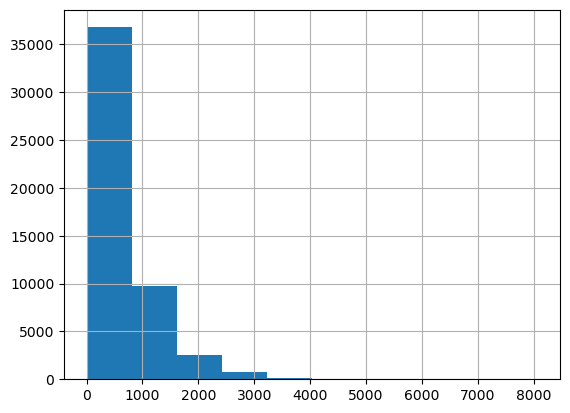

In [45]:
df['review'].str.len().hist()

In [10]:
#check if all the reviews are lower case
df['review'].str.islower().value_counts()

True    49998
Name: review, dtype: int64

In [27]:
df.describe().T


,count,unique,top,freq
review,49998,49576,loved todays show variety solely cooking great...,5
sentiment,50000,2,positive,25000


In [28]:
#find <br> tags in the reviews
df['review'].str.contains('<br>').value_counts()

False    49998
Name: review, dtype: int64

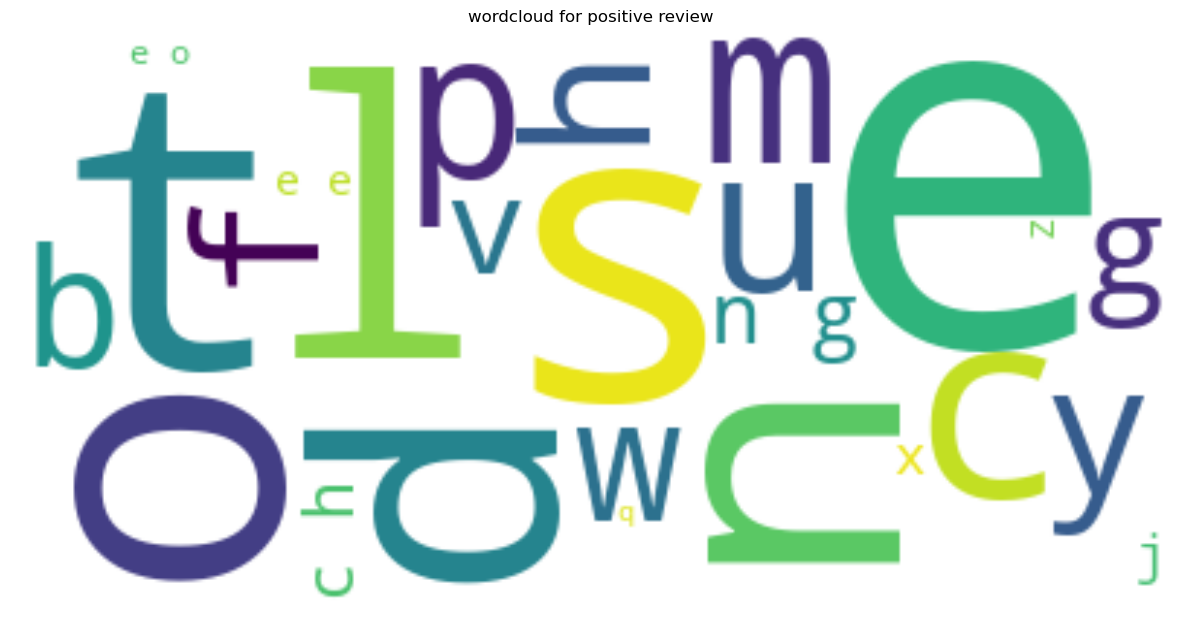

In [50]:
text = " ".join(str(df[df['sentiment']=='positive']['review'].values))
wordcloud = WordCloud( background_color="white").generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for positive review')
plt.show()

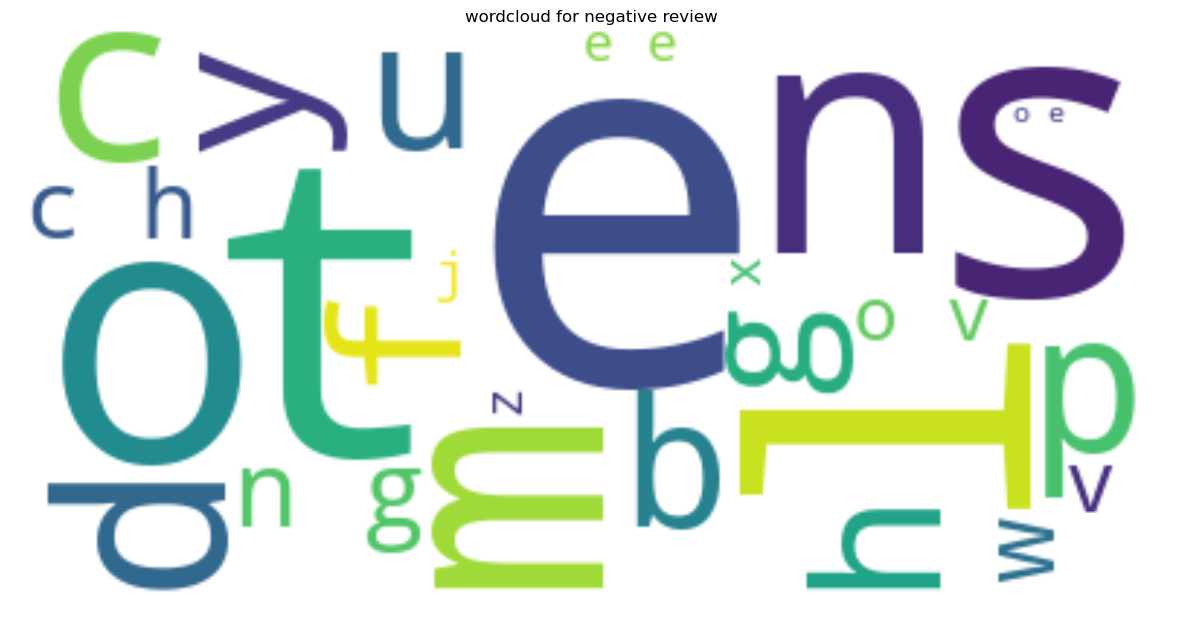

In [51]:
text = " ".join(str(df[df['sentiment']=='negative']['review'].values))
#stopwords = set(STOPWORDS)
wordcloud = WordCloud( background_color="white").generate(text)
#wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative review')
plt.show()

In [29]:
# dt = pd.DataFrame(dt)  
# dt['sentiment']=df['sentiment']
# dt

NameError: name 'dt' is not defined

In [56]:
df_new = df[df['review'].notnull()]


from collections import Counter
cnt = Counter()
for text in df_new["review"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp



,word,count
0,br,114697
1,movie,83449
2,film,74406
3,time,23245
4,story,22071
5,great,17808
6,movies,15439
7,made,15401
8,make,15292
9,films,15274


In [57]:
px.bar(temp, x="count", y="word", title='Commmon Words in Text', orientation='h', 
             width=700, height=700)

In [60]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
df_new["wo_stopfreq"] = df_new["review"].apply(lambda text: remove_freqwords(text))
df_new.head()

/var/folders/72/nxfcp8kj65bbt3qtv2krff1w0000gn/T/ipykernel_34897/1894961945.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,sentiment,wo_stopfreq
0,reviewers mentioned watching oz episode youll ...,positive,reviewers mentioned watching oz episode youll ...
1,wonderful production br br filming technique u...,positive,wonderful production filming technique unassum...
2,wonderful spend time hot summer weekend sittin...,positive,wonderful spend hot summer weekend sitting air...
3,basically family boy jake thinks zombie closet...,negative,basically family boy jake thinks zombie closet...
4,petter matteis love time money visually stunni...,positive,petter matteis love money visually stunning wa...


In [61]:
df_new['review'].loc[5]

'probably alltime favorite movie story selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd movie'

In [62]:
df_new['wo_stopfreq'].loc[5]

'probably alltime favorite selflessness sacrifice dedication noble preachy boring despite times years paul lukas performance brings tears eyes bette davis sympathetic roles delight kids grandma dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

In [64]:
# Lemmatization: Lemmatization is converting the word to its base form or lemma by removing affixes from the inflected words. 
# It helps to create better features for machine learning and NLP models hence it is an important preprocessing step.


wordnet_lem = WordNetLemmatizer()

df_new['wo_stopfreq_lem'] = df_new['wo_stopfreq'].apply(wordnet_lem.lemmatize)
df_new

/var/folders/72/nxfcp8kj65bbt3qtv2krff1w0000gn/T/ipykernel_34897/3974456937.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,review,sentiment,wo_stopfreq,wo_stopfreq_lem
0,reviewers mentioned watching oz episode youll ...,positive,reviewers mentioned watching oz episode youll ...,reviewers mentioned watching oz episode youll ...
1,wonderful production br br filming technique u...,positive,wonderful production filming technique unassum...,wonderful production filming technique unassum...
2,wonderful spend time hot summer weekend sittin...,positive,wonderful spend hot summer weekend sitting air...,wonderful spend hot summer weekend sitting air...
3,basically family boy jake thinks zombie closet...,negative,basically family boy jake thinks zombie closet...,basically family boy jake thinks zombie closet...
4,petter matteis love time money visually stunni...,positive,petter matteis love money visually stunning wa...,petter matteis love money visually stunning wa...
...,...,...,...,...
49995,movie job creative original expecting lotta fu...,positive,job creative original expecting lotta fun dvd ...,job creative original expecting lotta fun dvd ...
49996,plot dialogue acting idiotic directing annoyin...,negative,plot dialogue acting idiotic directing annoyin...,plot dialogue acting idiotic directing annoyin...
49997,catholic taught parochial elementary schools n...,negative,catholic taught parochial elementary schools n...,catholic taught parochial elementary schools n...
49998,disagree previous comment side maltin rate exc...,negative,disagree previous comment side maltin rate exc...,disagree previous comment side maltin rate exc...


## tokenization

In [65]:
df_copy = df_new.copy()

nb=df_copy.drop(columns=['review','wo_stopfreq'])
nb.columns=['sentiment','review']
nb.sentiment = [0 if each == "negative" else 1 for each in nb.sentiment]
nb

,sentiment,review
0,1,reviewers mentioned watching oz episode youll ...
1,1,wonderful production filming technique unassum...
2,1,wonderful spend hot summer weekend sitting air...
3,0,basically family boy jake thinks zombie closet...
4,1,petter matteis love money visually stunning wa...
...,...,...
49995,1,job creative original expecting lotta fun dvd ...
49996,0,plot dialogue acting idiotic directing annoyin...
49997,0,catholic taught parochial elementary schools n...
49998,0,disagree previous comment side maltin rate exc...


In [66]:
tokenized_review=nb['review'].apply(lambda x: x.split())
tokenized_review.head(5)

0    [reviewers, mentioned, watching, oz, episode, ...
1    [wonderful, production, filming, technique, un...
2    [wonderful, spend, hot, summer, weekend, sitti...
3    [basically, family, boy, jake, thinks, zombie,...
4    [petter, matteis, love, money, visually, stunn...
Name: review, dtype: object

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(nb['review'])

In [68]:
from sklearn.model_selection import train_test_split
X=text_counts
y=nb['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

4.5. Navies Bayes Modelling:
In this section, we will go through different Navies Bayes Model: ComplementNB, MultinatinominalNB, BernoulliNB and see how accuracy each model can be:

In [69]:
#Complement NB model:

from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

ComplementNB model accuracy is 86.30%
------------------------------------------------
Confusion Matrix:
      0     1
0  4312   605
1   765  4318
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4917
           1       0.88      0.85      0.86      5083

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [70]:
#Multinominal NB model:

from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

print('MultinominalNB model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

MultinominalNB model accuracy is 86.32%
------------------------------------------------
Confusion Matrix:
      0     1
0  4314   603
1   765  4318
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4917
           1       0.88      0.85      0.86      5083

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [71]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, predicted))

BernoulliNB model accuracy = 84.02%
------------------------------------------------
Confusion Matrix:
      0     1
0  4372   545
1  1053  4030
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      4917
           1       0.88      0.79      0.83      5083

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



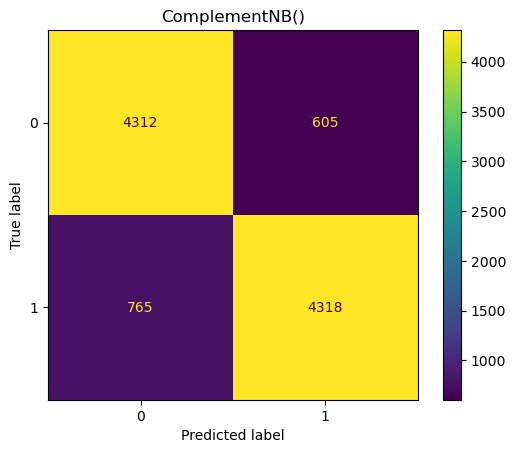

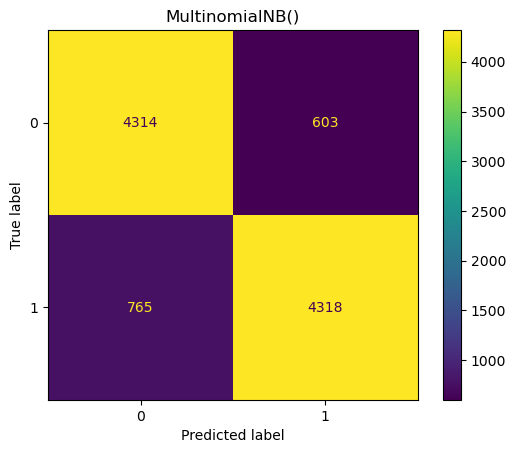

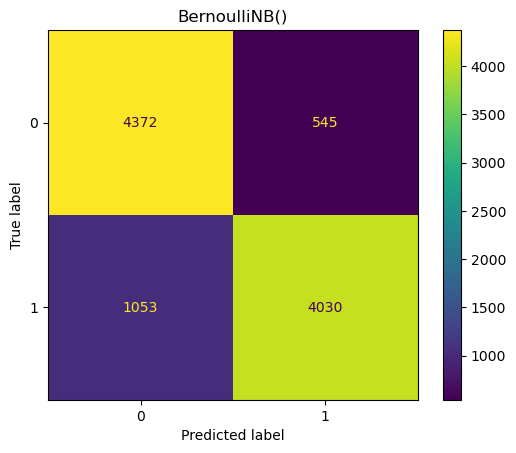

In [72]:
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")
k= [CNB, MNB, BNB]
for i in k: 
    plot_confusion_matrix(i, X_test, y_test)  
    plt.title(i)
    plt.show()

0.9279901569676541 0.9279893367416325 0.9255843340190824


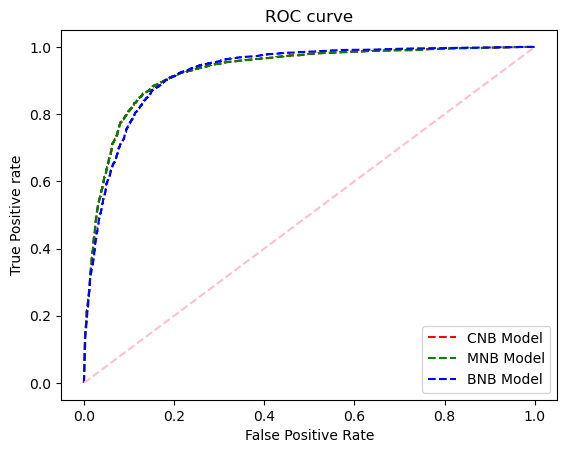

In [74]:
from sklearn.metrics import roc_curve

# predict probabilities for CNB, MNB, BNB models: 
CNB_prob = CNB.predict_proba(X_test)
MNB_prob = MNB.predict_proba(X_test)
BNB_prob = BNB.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
from sklearn.metrics import roc_auc_score
auc_CNB = roc_auc_score(y_test, CNB_prob[:,1])
auc_MNB = roc_auc_score(y_test, MNB_prob[:,1])
auc_BNB = roc_auc_score(y_test, BNB_prob[:,1])
print(auc_CNB, auc_MNB,auc_BNB)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

4.6 Trying different n-grams:

In [75]:
#4.6 Trying different n-grams:

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_twograms = CountVectorizer(stop_words='english',ngram_range = (2,2),tokenizer = token.tokenize)
text_counts_twograms = cv_twograms.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_twograms, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

model accuracy is 84.50%


In [76]:
#Trigram: ngram_range= (3,3)¶


token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv_threegrams = CountVectorizer(stop_words='english',ngram_range = (3,3),tokenizer = token.tokenize)
text_counts_threegrams = cv_threegrams.fit_transform(nb['review'])

X_train, X_test, y_train, y_test = train_test_split(text_counts_threegrams, nb['sentiment'], test_size=0.20,random_state=30)

MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)
print('model accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')

model accuracy is 60.51%


4.7 TF-IDF: Term Frequency-Inverse Document Frequency

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_count_2 = tfidf.fit_transform(nb['review'])



<49998x174212 sparse matrix of type '<class 'numpy.float64'>'
	with 3735961 stored elements in Compressed Sparse Row format>

In [88]:
#splitting the data in test and training
#from sklearn.model_selection() import train_test_split()
x_train, x_test, y_train, y_test = train_test_split(text_count_2, nb['sentiment'],test_size=0.20,random_state=30)




(39998,)


In [90]:
#fitting the model with MNB
MNB.fit(x_train, y_train)
accuracy_score_mnb = metrics.accuracy_score(MNB.predict(x_test), y_test)

print('accuracy_score_mnb = '+str('{:4.2f}'.format(accuracy_score_mnb*100))+'%')

accuracy_score_mnb = 86.05%


In [89]:
print(roc_auc_score(y_test, MNB.predict_proba(x_test)[:,1]))

0.9339895359581438

In [80]:
#fitting the model with BNB
BNB.fit(x_train, y_train)
accuracy_score_bnb = metrics.accuracy_score(BNB.predict(x_test), y_test)
print('accuracy_score_bnb = '+str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')

accuracy_score_bnb = 83.11%


In [91]:
roc_auc_score(y_test, BNB.predict_proba(x_test)[:,1])

0.9172303889215557

In [84]:
# fitting the model with CNB
CNB.fit(x_train, y_train)
accuracy_score_cnb = metrics.accuracy_score(CNB.predict(x_test), y_test)
print('accuracy_score_cnb = '+str('{:4.2f}'.format(accuracy_score_cnb*100))+'%')

accuracy_score_cnb = 86.04%


In [92]:
roc_auc_score(y_test, CNB.predict_proba(x_test)[:,1])

0.9339895359581438

In [93]:
sample = np.array(['This movie is really bad. I do not recommend it to anyone.'])
sample = tfidf.transform(sample)
print('MNB prediction: ',MNB.predict(sample))



MNB prediction:  [1]


In [25]:
# #do tokenization
# df['review'] = df['review'].apply(lambda x: x.split())
# df.head()
# df['review'].head()

AttributeError: 'float' object has no attribute 'split'